# 进化优化算法作业 3：蚁群优化算法解决 TSP 问题
  *郑晓旸 202111030007*

旅行商问题（Traveling Salesman Problem, TSP）是组合优化中的经典问题之一。其内容是给定一组城市及城市之间的距离，要求找出一条最短的路径，使得旅行商从某一城市出发，经过每个城市且仅经过一次，最后回到出发城市。

TSP 的主要难题在于其计算复杂度。随着城市数量的增加，可能的路径组合数呈指数级增长，导致穷举法在实际应用中不可行。因此，寻找高效的近似算法成为解决 TSP 的关键。

蚁群算法（Ant Colony Optimization, ACO）是一种基于自然界蚂蚁觅食行为的启发式算法。蚂蚁通过在路径上留下信息素来指引其他蚂蚁选择路径。ACO 通过模拟这一过程，逐步优化路径选择，最终找到 TSP 的近似最优解。具体来说，蚁群算法通过多次迭代，利用信息素的正反馈机制和路径选择的随机性，逐步收敛到最优或近似最优的路径。

## 详细说明：
本问题中给定 14 个城市的坐标，使用蚁群优化算法或其他优化的启发式算法寻找一条最短的遍历所有城市的路径。

以下是这 14 个城市的坐标：
| 城市编号 | X 坐标 | Y 坐标 | 城市编号 | X 坐标 | Y 坐标 |
|---------|-------|-------|---------|-------|-------|
| 1       | 16.47 | 96.10 | 8       | 17.20 | 96.29 |
| 2       | 16.47 | 94.44 | 9       | 16.30 | 97.38 |
| 3       | 20.09 | 92.54 | 10      | 14.05 | 98.12 |
| 4       | 22.39 | 93.37 | 11      | 16.53 | 97.38 |
| 5       | 25.23 | 97.24 | 12      | 21.52 | 95.59 |
| 6       | 22.00 | 96.05 | 13      | 19.41 | 97.13 |
| 7       | 20.47 | 97.02 | 14      | 20.09 | 92.55 |

## Part A. 问题解决思路简述
蚁群算法（ACO）解决 TSP 问题的思路如下：

1. **初始化**：
    - 初始化信息素矩阵，每条路径上的信息素初始值相同。
    - 设置算法参数，如蚂蚁数量、信息素重要性因子、启发式因子、信息素挥发系数等。

2. **构建解**：
    - 每只蚂蚁从一个随机选择的城市出发。
    - 根据概率选择下一个城市，概率由信息素浓度和启发式信息（如城市间距离的倒数）共同决定。
    - 重复上述步骤，直到蚂蚁遍历完所有城市，形成一条完整路径。

3. **更新信息素**：
    - 根据蚂蚁走过的路径长度更新信息素。路径越短，信息素增加越多。
    - 信息素挥发，防止过早收敛到局部最优解。

4. **迭代**：
    - 重复构建解和更新信息素的过程，直到达到预定的迭代次数或满足其他终止条件。

5. **输出结果**：
    - 记录并输出迭代过程中找到的最优路径及其长度。

## Part B. 基本算法求解

### B.1 引入函数库

In [267]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

### B.2 导入问题数据

In [268]:

city_data = np.array([
    [1, 16.47, 96.10],
    [2, 16.47, 94.44],
    [3, 20.09, 92.54],
    [4, 22.39, 93.37],
    [5, 25.23, 97.24],
    [6, 22.00, 96.05],
    [7, 20.47, 97.02],
    [8, 17.20, 96.29],
    [9, 16.30, 97.38],
    [10, 14.05, 98.12],
    [11, 16.53, 97.38],
    [12, 21.52, 95.59],
    [13, 19.41, 97.13],
    [14, 20.09, 92.55]
])

### B.3 确定蚁群算法基本函数

#### B.3.1 距离矩阵计算
计算距离矩阵的思路如下：

1. **初始化距离矩阵**：创建一个大小为 `num_cities x num_cities` 的矩阵 `distance_matrix`，并将其所有元素初始化为零。

2. **计算城市间距离**：使用双重循环遍历每对城市 `(i, j)`，计算城市 `i` 和城市 `j` 之间的欧几里得距离，并将结果存储在 `distance_matrix[i][j]` 中。具体计算公式为：
    \[
    \text{distance\_matrix}[i][j] = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}
    \]
    其中，`x_i` 和 `y_i` 分别是城市 `i` 的 X 坐标和 Y 坐标。

3. **返回距离矩阵**：完成所有城市间距离的计算后，返回距离矩阵 `distance_matrix`。

该方法的时间复杂度为 \(O(n^2)\)，其中 \(n\) 是城市的数量。


In [269]:
# 计算城市间距离
def calculate_distance(city_data):
    num_cities = city_data.shape[0]
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                distance_matrix[i][j] = np.sqrt((city_data[i][1] - city_data[j][1])**2 + (city_data[i][2] - city_data[j][2])**2)
    return distance_matrix

#### B.3.2 初始化信息素矩阵
蚁群算法中的信息素矩阵初始化步骤如下：

1. **确定初始信息素值**：根据问题规模和算法参数，设定每条路径上的初始信息素值 `initial_pheromone`。初始信息素值通常是一个较小的正数，用于表示路径上的初始吸引力。

2. **创建信息素矩阵**：创建一个大小为 `num_cities x num_cities` 的矩阵 `pheromone_matrix`，并将其所有元素初始化为 `initial_pheromone`。该矩阵用于存储每条路径上的信息素浓度。

3. **返回信息素矩阵**：完成信息素矩阵的初始化后，返回该矩阵 `pheromone_matrix`。

该方法的时间复杂度为 \(O(n^2)\)，其中 \(n\) 是城市的数量。

In [385]:
# 初始化信息素矩阵
def initialize_pheromone_matrix(num_cities, initial_pheromone):
    return np.full((num_cities, num_cities), initial_pheromone)

#### B.3.3 创建蚁群中个体的选择算法

蚁群算法中个体选择下一个城市的算法原理如下：

1. **计算选择概率**：
    - 对于当前城市 `current_city`，计算每个未访问城市 `i` 的选择概率。选择概率由信息素浓度 `pheromone_matrix[current_city][i]` 和启发式信息（如城市间距离的倒数 (`1.0 / distance_matrix[current_city][i]`）共同决定。
    - 使用参数 `alpha` 和 `beta` 分别控制信息素和启发式信息的重要性。具体计算公式为：
      $$
      \text{probabilities}[i] = (\text{pheromone\_matrix[current\_city][i]} ^ \alpha) \times \left(\frac{1.0}{\text{distance\_matrix[current\_city][i]}}\right) ^ \beta
      $$
    - 对所有未访问城市的选择概率进行归一化处理，使其总和为1。

2. **选择下一个城市**：
    - 根据计算得到的选择概率，使用随机抽样的方法选择下一个城市。选择概率越高的城市，被选择的可能性越大。
    - 如果所有未访问城市的选择概率总和为0，则随机选择一个未访问的城市。

该方法通过结合信息素和启发式信息，平衡了探索新路径和利用已有信息的需求，从而提高了算法的全局搜索能力。

In [271]:
# 选择下一个城市
def select_next_city(pheromone_matrix, distance_matrix, visited, current_city, alpha, beta):
    num_cities = pheromone_matrix.shape[0]
    probabilities = np.zeros(num_cities)
    for i in range(num_cities):
        if i not in visited:
            probabilities[i] = (pheromone_matrix[current_city][i] ** alpha) * ((1.0 / distance_matrix[current_city][i]) ** beta)
    probabilities_sum = probabilities.sum()
    if probabilities_sum == 0:
        return np.random.choice([i for i in range(num_cities) if i not in visited])
    probabilities /= probabilities_sum
    return np.random.choice(range(num_cities), p=probabilities)

#### B.3.4 信息素矩阵更新算法
信息素矩阵更新的原理如下：

1. **信息素挥发**：
    - 信息素矩阵中的每个元素都会按照一定的挥发率 `evaporation_rate` 进行衰减。具体公式为：
      $$
      \text{pheromone\_matrix}[i][j] = \text{pheromone\_matrix}[i][j] \times (1 - \text{evaporation\_rate})
      $$
    - 这一过程模拟了自然界中信息素随时间的自然挥发，防止算法过早收敛到局部最优解。

2. **信息素增加**：
    - 对于每只蚂蚁找到的路径，根据路径长度 `length` 更新路径上的信息素浓度。具体公式为：
      $$
      \text{pheromone\_matrix}[path[i]][path[i + 1]] += \frac{Q}{length}
      $$
    - 其中，`Q` 是一个常数，表示信息素的总量。路径越短，单位路径上的信息素增加越多，增强了该路径的吸引力。

3. **循环更新**：
    - 对所有蚂蚁找到的路径进行上述信息素增加的操作，确保每条路径上的信息素浓度都能反映其优劣。

通过信息素的挥发和增加，蚁群算法能够逐步优化路径选择，最终找到 TSP 的近似最优解。

In [272]:
# 更新信息素矩阵
def update_pheromone_matrix(pheromone_matrix, all_paths, distance_matrix, evaporation_rate, Q):
    num_cities = pheromone_matrix.shape[0]
    pheromone_matrix *= (1 - evaporation_rate)
    for path, length in all_paths:
        for i in range(num_cities - 1):
            pheromone_matrix[path[i]][path[i + 1]] += Q / length
        pheromone_matrix[path[-1]][path[0]] += Q / length

#### B.3.5 蚁群初始化算法
根据蚁群数量和城市数量，随机分配蚁群到各个城市。

In [273]:
def generate_initial_ants(num_ants, num_cities):
    ants = []
    for _ in range(num_ants):
        start_city = np.random.randint(num_cities)
        ants.append([start_city])
    return ants

#### B.3.6 蚁群迁移算法
蚁群迁移算法的步骤如下：

1. **初始化蚂蚁位置**：
    从输入的蚁群位置开始。

2. **选择下一个城市**：
    - 根据当前城市和未访问城市之间的信息素浓度和启发式信息，计算每个未访问城市的选择概率。
    - 使用轮盘赌法或其他随机选择方法，根据选择概率选择下一个城市。
    - 将选择的城市标记为已访问，并更新当前城市。

3. **完成路径**：
    - 重复选择下一个城市的步骤，直到蚂蚁遍历完所有城市，形成一条完整路径。
    - 记录蚂蚁的路径和路径长度。

4. **更新信息素**：
    - 根据蚂蚁走过的路径长度更新路径上的信息素浓度。路径越短，信息素增加越多。
    - 信息素挥发，防止过早收敛到局部最优解。

5. **迭代**：
    - 重复蚂蚁迁移和信息素更新的过程，直到达到预定的迭代次数或满足其他终止条件。

通过上述步骤，蚁群算法能够逐步优化路径选择，最终找到 TSP 的近似最优解。

In [274]:
def move_ants(pheromone_matrix, distance_matrix, ants, alpha, beta):
    num_cities = pheromone_matrix.shape[0]
    new_ants = []
    
    for ant in ants:
        visited = ant[:]
        current_city = visited[-1]
        
        probabilities = np.zeros(num_cities)
        for i in range(num_cities):
            if i not in visited:
                probabilities[i] = (pheromone_matrix[current_city][i] ** alpha) * ((1.0 / distance_matrix[current_city][i]) ** beta)
        
        probabilities_sum = probabilities.sum()
        if probabilities_sum == 0:
            next_city = np.random.choice([i for i in range(num_cities) if i not in visited])
        else:
            probabilities /= probabilities_sum
            next_city = np.random.choice(range(num_cities), p=probabilities)
        
        visited.append(next_city)
        new_ants.append(visited)
    
    return new_ants

### B.4 基本蚁群算法
蚁群算法（Ant Colony Optimization, ACO）是一种基于自然界蚂蚁觅食行为的启发式算法，广泛应用于解决组合优化问题，如旅行商问题（TSP）。其基本思想是通过模拟蚂蚁在路径上留下信息素（pheromone），并根据信息素浓度选择路径，从而逐步优化路径选择，找到问题的近似最优解。

蚁群算法求解 TSP 的步骤如下：

1. **初始化**：
    - 初始化信息素矩阵，每条路径上的信息素初始值相同。
    - 设置算法参数，如蚂蚁数量、信息素重要性因子（alpha）、启发式因子（beta）、信息素挥发系数（evaporation_rate）等。

2. **构建解**：
    - 每只蚂蚁从一个随机选择的城市出发。
    - 根据概率选择下一个城市，概率由信息素浓度和启发式信息（如城市间距离的倒数）共同决定。
    - 重复上述步骤，直到蚂蚁遍历完所有城市，形成一条完整路径。

3. **更新信息素**：
    - 根据蚂蚁走过的路径长度更新信息素。路径越短，信息素增加越多。
    - 信息素挥发，防止过早收敛到局部最优解。

4. **迭代**：
    - 重复构建解和更新信息素的过程，直到达到预定的迭代次数或满足其他终止条件。

5. **输出结果**：
    - 记录并输出迭代过程中找到的最优路径及其长度。

通过上述步骤，蚁群算法能够逐步优化路径选择，最终找到 TSP 的近似最优解。

基于之前的作业，我们这里可以使用早停法优化迭代步数。

早停法（Early Stopping）是一种用于防止算法过拟合的技术。在蚁群算法中，早停法可以用于优化迭代步数，避免在没有显著改进的情况下进行不必要的计算。具体步骤如下：

1. **设定耐心值（Patience）**：
    - 设定一个耐心值 `patience`，表示在多少次迭代中没有找到更优解时停止算法。

2. **记录最优解**：
    - 在每次迭代中，记录当前找到的最优路径及其长度。

3. **判断是否早停**：
    - 如果在连续 `patience` 次迭代中，最优路径长度没有显著改进，则停止算法。

通过早停法，可以在保证解的质量的前提下，减少计算时间，提高算法的效率。

In [275]:
# 蚁群算法求解 TSP，加入早停法
def ant_colony_optimization(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, initial_pheromone, patience):
    num_cities = city_data.shape[0]
    distance_matrix = calculate_distance(city_data)
    pheromone_matrix = initialize_pheromone_matrix(num_cities, initial_pheromone)
    
    best_path = None
    best_length = float('inf')
    best_length_overiterations = float('inf')
    no_improvement_count = 0
    
    for iteration in range(num_iterations):
        all_paths = []
        for ant in range(num_ants):
            visited = []
            current_city = np.random.randint(num_cities)
            visited.append(current_city)
            
            while len(visited) < num_cities:
                next_city = select_next_city(pheromone_matrix, distance_matrix, visited, current_city, alpha, beta)
                visited.append(next_city)
                current_city = next_city
            
            path_length = sum(distance_matrix[visited[i]][visited[i + 1]] for i in range(num_cities - 1))
            path_length += distance_matrix[visited[-1]][visited[0]]
            all_paths.append((visited, path_length))
        
        update_pheromone_matrix(pheromone_matrix, all_paths, distance_matrix, evaporation_rate, Q)
        
        for path, length in all_paths:
            if length < best_length:
                best_length = length
                best_path = path
        if best_length < best_length_overiterations:
            best_length_overiterations = best_length
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at iteration {iteration + 1}")
            break
    
    return best_path, best_length

#### B.4.2 运行基础蚁群算法
##### 参数选择和运行结果

在运行蚁群算法时，我们选择了以下参数：

- 蚂蚁数量（num_ants）：20
- 迭代次数（num_iterations）：300
- 信息素重要性因子（alpha）：1
- 启发式因子（beta）：5
- 信息素挥发系数（evaporation_rate）：0.0
- 信息素总量（Q）：10
- 初始信息素值（initial_pheromone）：0.7
- 早停法耐心值（patience）：300

运行结果如下：

- 最优路径（best_path）：[6, 12, 7, 13, 8, 11, 9, 10, 1, 2, 14, 3, 4, 5, 6]
- 最优路径长度（best_length）：29.340520066994223

In [320]:
# 设置参数并运行算法
num_ants = 14
num_iterations = 3000
alpha = 1
beta = 5
evaporation_rate = 0.99
Q = 100
initial_pheromone = 0.1
patience = 500

best_path, best_length = ant_colony_optimization(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, initial_pheromone,patience)
best_path = [city + 1 for city in best_path]
baest_path = best_path.append(best_path[0])
print("Best path:", best_path)
print("Best path length:", best_length)
print("Time Complexity:",num_ants*num_iterations)

Early stopping at iteration 758
Best path: [9, 11, 13, 7, 12, 6, 5, 4, 3, 14, 2, 8, 1, 10, 9]
Best path length: 29.670782381507852
Time Complexity: 42000


#### B.4.2.2 结果可视化

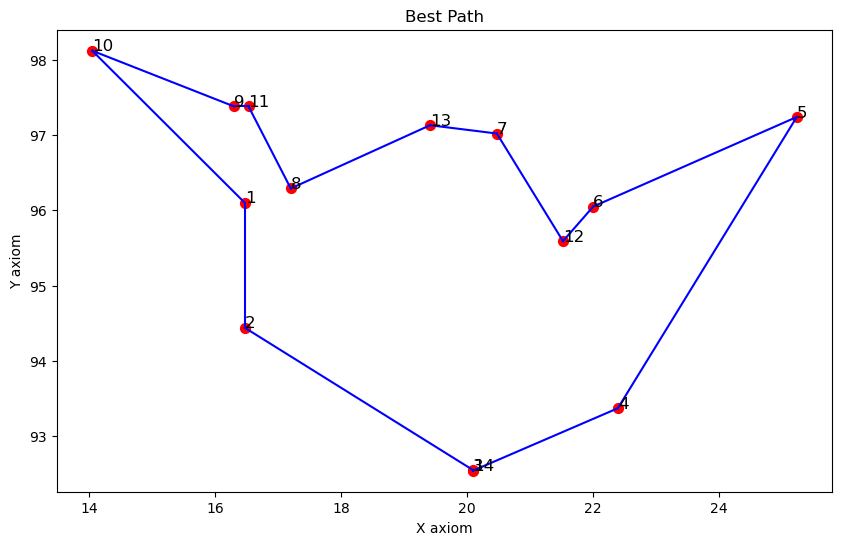

In [310]:
plt.figure(figsize=(10, 6))
for i in range(num_cities):
    plt.scatter(city_data[i, 1], city_data[i, 2], c='red', s=50)
    plt.text(city_data[i, 1], city_data[i, 2], str(int(city_data[i, 0])), fontsize=12)

for i in range(len(best_path) - 1):
    start = best_path[i] - 1
    end = best_path[i + 1] - 1
    plt.plot([city_data[start, 1], city_data[end, 1]], 
             [city_data[start, 2], city_data[end, 2]], c='blue')
plt.title("Best Path")
plt.xlabel("X axiom")
plt.ylabel("Y axiom")
plt.show()

In [467]:
true_best_path = [6, 12, 7, 13, 8, 11, 9, 10, 1, 2, 14, 3, 4, 5, 6]
true_best_length = 29.340520066994223

#### B.4.2.3 结果稳定性测试

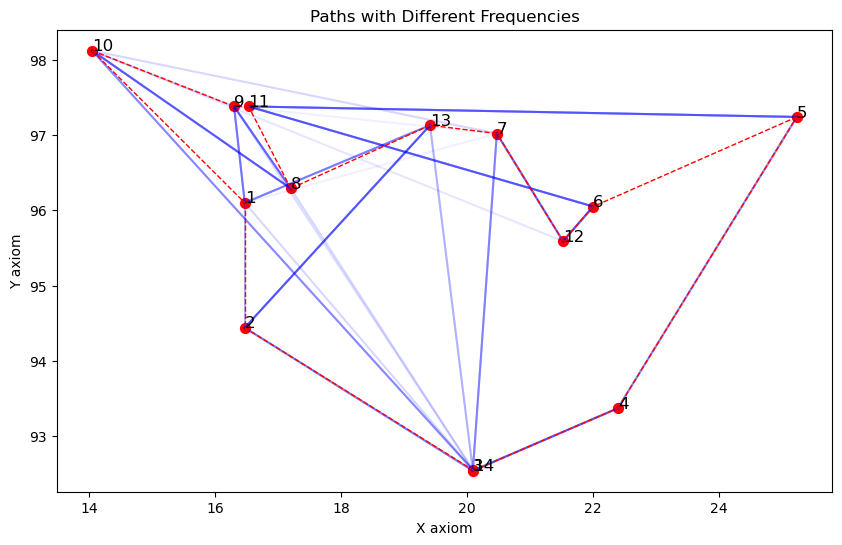

In [391]:
from collections import defaultdict
# 设置参数并运行算法
num_ants = 14
num_iterations = 300
alpha = 1
beta = 5
evaporation_rate = 0.99
Q = 100
initial_pheromone = 0.1
patience = 300
# 运行蚁群算法 50 次，并记录每次的最优路径及其长度
num_runs = 50
results = defaultdict(int)
record = dict()
for _ in range(num_runs):
    best_path, best_length = ant_colony_optimization(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, initial_pheromone, patience)
    results[best_length] += 1
    record[best_length] = best_path
# 绘制路径图，出现次数越多，路径颜色越深
plt.figure(figsize=(10, 6))
for i in range(num_cities):
    plt.scatter(city_data[i, 1], city_data[i, 2], c='red', s=50)
    plt.text(city_data[i, 1], city_data[i, 2], str(int(city_data[i, 0])), fontsize=12)

for length, count in results.items():
    best_path = record[length]
    for i in range(len(best_path) - 1):
        start = best_path[i] - 1
        end = best_path[i + 1] - 1
        plt.plot([city_data[start, 1], city_data[end, 1]], 
                 [city_data[start, 2], city_data[end, 2]], 
                 c='blue', alpha=count / num_runs)
        
# 绘制最短路径
for i in range(len(true_best_path) - 1):
    start = true_best_path[i] - 1
    end = true_best_path[i + 1] - 1
    plt.plot([city_data[start, 1], city_data[end, 1]], 
             [city_data[start, 2], city_data[end, 2]], 
             c='red', linestyle='--', linewidth=1)

plt.title("Paths with Different Frequencies")
plt.xlabel("X axiom")
plt.ylabel("Y axiom")
plt.show()

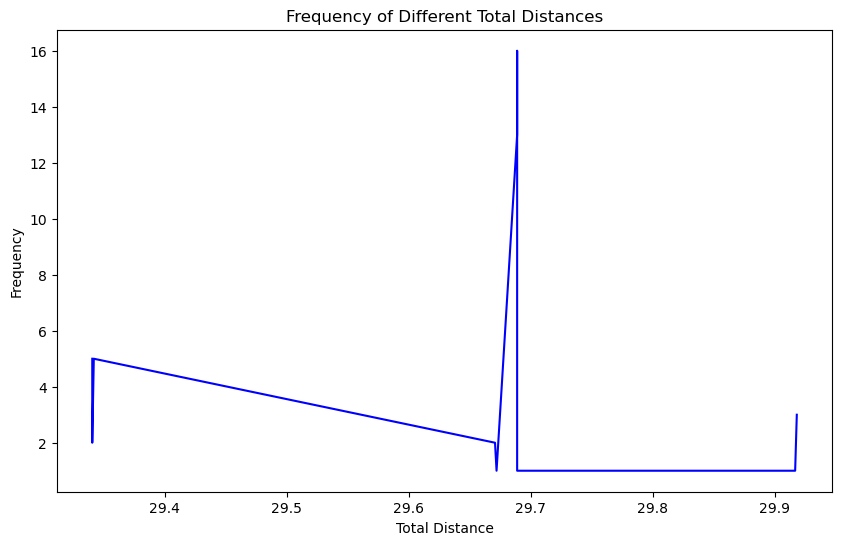

In [313]:
# 提取距离和频次
distances = list(results.keys())
frequencies = list(results.values())

# 按照距离排序
sorted_indices = np.argsort(distances)
sorted_distances = np.array(distances)[sorted_indices]
sorted_frequencies = np.array(frequencies)[sorted_indices]

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, sorted_frequencies, color='blue')
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.title('Frequency of Different Total Distances')
plt.show()

观察解得到的结果发现结果正确率相当低，提高迭代次数或者改进参数对结果正确率并没有很大的提升，我们需要更好的算法……

## Part C. 算法改进
在前面的实验中，我们发现原本的蚁群算法在解决 TSP 问题时，结果的正确率相对较低。即使增加迭代次数或调整参数，对结果的提升也不明显。因此，我们需要对算法进行改进，以提高其性能和结果的准确性。

### 改进思路
1. **改善初始信息素浓度**：
    - 初始信息素浓度对算法的收敛速度和结果有重要影响。可以根据城市间距离的倒数来设置初始信息素浓度，使得初始信息素浓度更具指导性。

2. **动态调整参数**：
    - 在算法运行过程中，动态调整参数（如信息素重要性因子 alpha 和启发式因子 beta），以平衡探索和利用的关系，避免陷入局部最优解。

3. **引入蚁群模型**：
    - 在 模型中，蚁群采用了不同的状态转换规则（伪随机选ACS取规则），这使得关于问题的先验知识得到了更好的利用，强化了算法的局部搜索能力
4. **多种信息素更新策略**：
    - 结合多种信息素更新策略，如全局最优路径信息素更新和局部最优路径信息素更新，增强算法的全局搜索能力。

5. **增加信息素挥发率的自适应调整**：
    - 根据迭代次数和当前最优解的变化情况，自适应调整信息素挥发率，防止信息素过度积累或过快挥发。

通过上述改进思路，我们可以在保持算法全局搜索能力的同时，提高其收敛速度和结果的准确性。


### C.1 改进初始信息素浓度
将初始信息素浓度从无附加值或者常数改为与路径长度负相关的数字，从而节省迭代次数达到快递收敛的目的。

In [325]:
def initialize_pheromone_matrix_by_distance(distance_matrix, Q):
    num_cities = distance_matrix.shape[0]
    pheromone_matrix = np.zeros((num_cities, num_cities))
    
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                pheromone_matrix[i][j] = Q / distance_matrix[i][j]
            else:
                pheromone_matrix[i][j] = 1e-10  # 避免除以零的情况
    
    return pheromone_matrix

根据上面的信息素初始化函数修改主函数

In [371]:
# 蚁群算法求解 TSP，加入修改的信息素初始化方法
def ant_colony_optimization_mod1(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, patience):
    num_cities = city_data.shape[0]
    distance_matrix = calculate_distance(city_data)
    pheromone_matrix = initialize_pheromone_matrix_by_distance(distance_matrix, Q*10)
    
    best_path = None
    best_length = float('inf')
    best_length_overiterations = float('inf')
    no_improvement_count = 0
    
    for iteration in range(num_iterations):
        all_paths = []
        for ant in range(num_ants):
            visited = []
            current_city = np.random.randint(num_cities)
            visited.append(current_city)
            
            while len(visited) < num_cities:
                next_city = select_next_city(pheromone_matrix, distance_matrix, visited, current_city, alpha, beta)
                visited.append(next_city)
                current_city = next_city
            
            path_length = sum(distance_matrix[visited[i]][visited[i + 1]] for i in range(num_cities - 1))
            path_length += distance_matrix[visited[-1]][visited[0]]
            all_paths.append((visited, path_length))
        
        update_pheromone_matrix(pheromone_matrix, all_paths, distance_matrix, evaporation_rate, Q)
        
        for path, length in all_paths:
            if length < best_length:
                best_length = length
                best_path = path
        if best_length < best_length_overiterations:
            best_length_overiterations = best_length
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at iteration {iteration + 1}")
            break
    
    return best_path, best_length

使用上面的主函数测试：

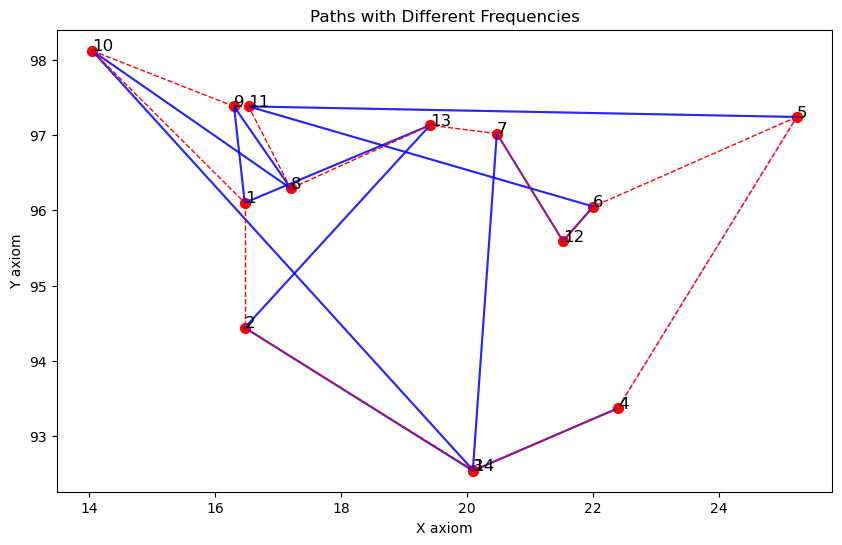

In [392]:
# 设置参数并运行算法
num_ants = 50
num_iterations = 300
alpha = 1
beta = 10
evaporation_rate = 0.9
Q = 1
patience = 300

# 运行蚁群算法 50 次，并记录每次的最优路径及其长度
num_runs = 50
results = defaultdict(int)
record = dict()

for _ in range(num_runs):
    best_path, best_length = ant_colony_optimization_mod1(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, patience)
    results[best_length] += 1
    record[best_length] = best_path
# 绘制路径图，出现次数越多，路径颜色越深
plt.figure(figsize=(10, 6))
for i in range(num_cities):
    plt.scatter(city_data[i, 1], city_data[i, 2], c='red', s=50)
    plt.text(city_data[i, 1], city_data[i, 2], str(int(city_data[i, 0])), fontsize=12)

for length, count in results.items():
    best_path = record[length]
    for i in range(len(best_path) - 1):
        start = best_path[i] - 1
        end = best_path[i + 1] - 1
        plt.plot([city_data[start, 1], city_data[end, 1]], 
                 [city_data[start, 2], city_data[end, 2]], 
                 c='blue', alpha=count / num_runs)

# 绘制最短路径
for i in range(len(true_best_path) - 1):
    start = true_best_path[i] - 1
    end = true_best_path[i + 1] - 1
    plt.plot([city_data[start, 1], city_data[end, 1]], 
             [city_data[start, 2], city_data[end, 2]], 
             c='red', linestyle='--', linewidth=1)

plt.title("Paths with Different Frequencies")
plt.xlabel("X axiom")
plt.ylabel("Y axiom")
plt.show()

我们发现该方法会导致算法容易收敛在局部次优解上，这需要我们引入新的方法对冲。

## C.2 引入蚁群算法

蚁群系统（Ant Colony System, ACS）是蚁群算法的一种改进版本，旨在提高算法的收敛速度和解的质量。ACS 通过引入局部更新规则和全局更新规则，增强了算法的探索能力和利用能力。

### ACS 的主要特点

1. **伪随机比例规则**：
    - 在选择下一个城市时，ACS 使用伪随机比例规则（Pseudo-Random Proportional Rule），结合信息素浓度和启发式信息，平衡探索和利用。
    - 具体公式为：
      $$
      j = \begin{cases} 
      \arg\max_{u \in J_k(i)} \left\{ \tau_{iu} \cdot \eta_{iu}^\beta \right\} & \text{if } q \leq q_0 \\
      \text{随机选择} & \text{否则}
      \end{cases}
      $$
      其中，$\tau_{iu}$ 是信息素浓度，$\eta_{iu}$ 是启发式信息，$\beta$ 是启发式因子，$q$ 是随机数，$q_0$ 是预设阈值。

2. **局部更新规则**：
    - 在每次蚂蚁选择路径后，对路径上的信息素进行局部更新，防止信息素过度积累。
    - 具体公式为：
      $$
      \tau_{ij} = (1 - \rho) \cdot \tau_{ij} + \rho \cdot \tau_0
      $$
      其中，$\rho$ 是局部信息素更新系数，$\tau_0$ 是初始信息素浓度。

3. **全局更新规则**：
    - 在每次迭代结束后，对全局最优路径上的信息素进行更新，增强最优路径的吸引力。
    - 具体公式为：
      $$
      \tau_{ij} = (1 - \alpha) \cdot \tau_{ij} + \alpha \cdot \Delta \tau_{ij}
      $$
      其中，$\alpha$ 是全局信息素更新系数，$\Delta \tau_{ij}$ 是信息素增量，通常与路径长度成反比。

通过上述改进，ACS 能够更快地收敛到高质量的解，适用于解决复杂的组合优化问题，如旅行商问题（TSP）。

In [397]:
def ant_colony_system(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, rho, q0, patience):
    num_cities = city_data.shape[0]
    distance_matrix = calculate_distance(city_data)
    pheromone_matrix = initialize_pheromone_matrix_by_distance(distance_matrix, Q * 10)
    visibility = 1.0 / (distance_matrix + np.diag([1e10] * num_cities))  # 避免除以零

    best_path = None
    best_length = float('inf')
    best_length_overiterations = float('inf')
    no_improvement_count = 0

    for iteration in range(num_iterations):
        all_paths = []
        for ant in range(num_ants):
            visited = []
            current_city = np.random.randint(num_cities)
            visited.append(current_city)

            while len(visited) < num_cities:
                if np.random.rand() < q0:
                    # 伪随机比例规则选择下一个城市
                    next_city = np.argmax(pheromone_matrix[current_city] * (visibility[current_city] ** beta))
                    if next_city in visited:
                        next_city = np.random.choice([i for i in range(num_cities) if i not in visited])
                else:
                    # 根据概率选择下一个城市
                    probabilities = (pheromone_matrix[current_city] ** alpha) * (visibility[current_city] ** beta)
                    probabilities[visited] = 0
                    probabilities_sum = probabilities.sum()
                    if probabilities_sum == 0:
                        next_city = np.random.choice([i for i in range(num_cities) if i not in visited])
                    else:
                        probabilities /= probabilities_sum
                        next_city = np.random.choice(range(num_cities), p=probabilities)

                visited.append(next_city)
                # 局部信息素更新
                pheromone_matrix[current_city][next_city] = (1 - rho) * pheromone_matrix[current_city][next_city] + rho * Q / distance_matrix[current_city][next_city]
                current_city = next_city

            # 计算路径长度
            path_length = sum(distance_matrix[visited[i]][visited[i + 1]] for i in range(num_cities - 1))
            path_length += distance_matrix[visited[-1]][visited[0]]
            all_paths.append((visited, path_length))

        # 更新全局最优路径
        for path, length in all_paths:
            if length < best_length:
                best_length = length
                best_path = path
        if best_length < best_length_overiterations:
            best_length_overiterations = best_length
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at iteration {iteration + 1}")
            break

        # 全局信息素更新
        best_ant_path, best_ant_length = min(all_paths, key=lambda x: x[1])
        for i in range(num_cities - 1):
            pheromone_matrix[best_ant_path[i]][best_ant_path[i + 1]] = (1 - evaporation_rate) * pheromone_matrix[best_ant_path[i]][best_ant_path[i + 1]] + evaporation_rate * Q / best_ant_length
        pheromone_matrix[best_ant_path[-1]][best_ant_path[0]] = (1 - evaporation_rate) * pheromone_matrix[best_ant_path[-1]][best_ant_path[0]] + evaporation_rate * Q / best_ant_length

    return best_path, best_length

Best path: [6, 12, 7, 13, 8, 11, 9, 10, 1, 2, 14, 3, 4, 5, 6]
Best path length: 29.340520066994223


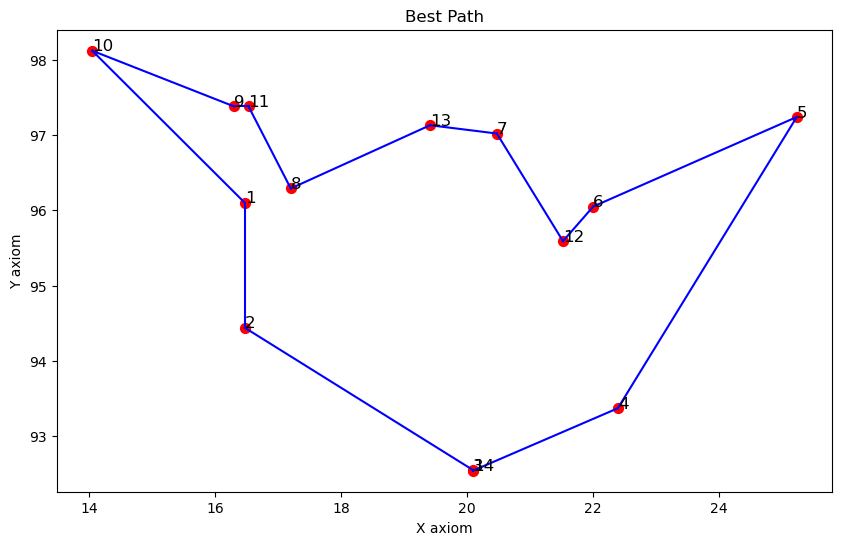

In [ ]:
# 设置参数并运行算法
num_ants = 50
num_iterations = 300
alpha = 1.5
beta = 4
evaporation_rate = 0.4
Q = 1
rho = 0.1
q0 = 0.7
patience = 300

best_path, best_length = ant_colony_system(city_data, num_ants, num_iterations, alpha, beta, evaporation_rate, Q, rho, q0, patience)
best_path = [city + 1 for city in best_path]
best_path.append(best_path[0])

print("Best path:", best_path)
print("Best path length:", best_length)
plt.figure(figsize=(10, 6))
for i in range(num_cities):
    plt.scatter(city_data[i, 1], city_data[i, 2], c='red', s=50)
    plt.text(city_data[i, 1], city_data[i, 2], str(int(city_data[i, 0])), fontsize=12)

for i in range(len(best_path) - 1):
    start = best_path[i] - 1
    end = best_path[i + 1] - 1
    plt.plot([city_data[start, 1], city_data[end, 1]], 
             [city_data[start, 2], city_data[end, 2]], c='blue')
plt.title("Best Path")
plt.xlabel("X axiom")
plt.ylabel("Y axiom")
plt.show()